# Analyze Negotiation Results

This notebook loads a negotiation log CSV, ignores the `conversation_history` column, parses item valuations and final allocations, and computes per‑round metrics for later plotting:
- Agent 1 Utility
- Agent 2 Utility
- Current Welfare
- Max Welfare
- Welfare Efficiency (current/max)

Run the cells below and use the last cell to quickly verify values for the first round.

In [242]:
from __future__ import annotations
import pandas as pd
import json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import math
from IPython.display import display

pd.options.display.width = 120
pd.options.display.max_colwidth = 200


In [243]:
LOG_PATH = "logs\gpt-oss_20b_default_vs_boulware_4_20250929_1529.csv"

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
C:\Users\zacha\AppData\Local\Temp\ipykernel_20068\184134197.py:1: SyntaxWarning: invalid escape sequence '\g'
  LOG_PATH = "logs\gpt-oss_20b_default_vs_boulware_4_20250929_1529.csv"


In [244]:
def parse_items_data(items_str: str) -> Dict[str, Dict[str, float]]:
    """Parse the items_data JSON into a mapping {item_name: {'agent1': float, 'agent2': float}}."""
    if items_str is None or (isinstance(items_str, float) and math.isnan(items_str)) or items_str == "":
        return {}
    data = json.loads(items_str)
    items: Dict[str, Dict[str, float]] = {}
    for item in data:
        name = item.get("name")
        if not name:
            # Skip malformed entries
            continue
        a1_val = float(item.get("agent1_value", 0.0))
        a2_val = float(item.get("agent2_value", 0.0))
        items[name] = {"agent1": a1_val, "agent2": a2_val}
    return items

def parse_final_allocation(alloc_str: str) -> Dict[str, List[str]]:
    """Parse the final_allocation JSON into {agent1: [...], agent2: [...]}. Accepts either keys 'agent1'/'agent2' or 'agent1_items'/'agent2_items'."""
    if alloc_str is None or (isinstance(alloc_str, float) and math.isnan(alloc_str)) or alloc_str == "":
        return {"agent1": [], "agent2": []}
    data = json.loads(alloc_str)
    a1_list = data.get("agent1", data.get("agent1_items", [])) or []
    a2_list = data.get("agent2", data.get("agent2_items", [])) or []
    # Ensure lists
    a1_list = list(a1_list)
    a2_list = list(a2_list)
    return {"agent1": a1_list, "agent2": a2_list}

def compute_round_metrics(items_map: Dict[str, Dict[str, float]], final_alloc: Dict[str, List[str]]) -> Dict[str, float]:
    """Compute normalized utilities and welfare metrics for a round."""
    # Compute raw utilities
    a1_util = sum(items_map[i]["agent1"] for i in final_alloc.get("agent1", []) if i in items_map)
    a2_util = sum(items_map[i]["agent2"] for i in final_alloc.get("agent2", []) if i in items_map)
    # Compute max possible utility for each agent in this round
    a1_max = sum(v["agent1"] for v in items_map.values()) if items_map else 1.0
    a2_max = sum(v["agent2"] for v in items_map.values()) if items_map else 1.0
    # Normalize utilities to [0, 1] for this round
    a1_util_norm = a1_util / a1_max if a1_max else 0.0
    a2_util_norm = a2_util / a2_max if a2_max else 0.0
    current_welfare = a1_util + a2_util
    max_welfare = sum(max(v["agent1"], v["agent2"]) for v in items_map.values())
    welfare_eff = (current_welfare / max_welfare) if max_welfare and max_welfare > 0 else math.nan
    return {
        "agent1_utility": a1_util_norm,
        "agent2_utility": a2_util_norm,
        "current_welfare": current_welfare,
        "max_welfare": max_welfare,
        "welfare_efficiency": welfare_eff,
        "agent1_utility_raw": a1_util,
        "agent2_utility_raw": a2_util,
        "agent1_utility_max": a1_max,
        "agent2_utility_max": a2_max,
    }

def _compute_metrics_row(row: pd.Series) -> pd.Series:
    items_map = parse_items_data(row.get("items_data"))
    final_alloc = parse_final_allocation(row.get("final_allocation"))
    metrics = compute_round_metrics(items_map, final_alloc)
    return pd.Series(metrics)

def load_log_file(csv_path: Path | str) -> pd.DataFrame:
    """Load a single CSV log file, ignoring 'conversation_history', and compute round metrics. Returns a DataFrame with original columns (minus conversation_history) plus the metrics columns."""
    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    # Read while ignoring the large conversation_history column
    df = pd.read_csv(
        path,
        engine="python",
        encoding="utf-8",
        usecols=lambda c: c != "conversation_history",
    )
    # Compute metrics per row
    metrics_df = df.apply(_compute_metrics_row, axis=1)
    out = pd.concat([df, metrics_df], axis=1)
    # Helpful type coercions for later plotting
    for col in ["round_number", "num_items", "turn_count", "starting_agent"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")
    return out


In [245]:
# Set your CSV path here. Defaults to one from the 'logs' folder if present.
default_csv = Path(LOG_PATH.replace("\\", "/"))
csv_path = default_csv if default_csv.exists() else None
if csv_path is None:
    print("Default CSV not found. Set 'csv_path' to your log file path, then run the next cell.")
else:
    print(f"Using CSV: {csv_path}")


Using CSV: logs\gpt-oss_20b_default_vs_boulware_4_20250929_1529.csv


In [246]:
if csv_path is not None:
    metrics_df = load_log_file(csv_path)
    print(f"Loaded {len(metrics_df)} rounds from {csv_path.name}")
    # Display the first few rows (excluding very long columns)
    cols_to_show = [
        c for c in metrics_df.columns
        if c not in {"items_data", "final_allocation", "proposal_history"}
    ] + ["agent1_utility", "agent2_utility", "current_welfare", "max_welfare", "welfare_efficiency"]
    display(metrics_df[cols_to_show].head(3))


Loaded 100 rounds from gpt-oss_20b_default_vs_boulware_4_20250929_1529.csv


,session_id,model_name,num_items,timestamp,date,agent1_type,agent2_type,boulware_initial_threshold,boulware_decrease_rate,boulware_min_threshold,...,welfare_efficiency,agent1_utility_raw,agent2_utility_raw,agent1_utility_max,agent2_utility_max,agent1_utility,agent2_utility,current_welfare,max_welfare,welfare_efficiency
0,gpt-oss_20b_default_vs_boulware_4_20250929_152918,gpt-oss_20b_default_vs_boulware,4,2025-09-29T15:29:23.652337,2025-09-29,default,boulware,0.85,0.03,0.1,...,1.000000,1.9,1.2,2.8,1.4,0.678571,0.857143,3.1,3.1,1.000000
1,gpt-oss_20b_default_vs_boulware_4_20250929_152918,gpt-oss_20b_default_vs_boulware,4,2025-09-29T15:29:59.784945,2025-09-29,default,boulware,0.85,0.03,0.1,...,0.884615,1.3,1.0,1.7,2.5,0.764706,0.400000,2.3,2.6,0.884615
2,gpt-oss_20b_default_vs_boulware_4_20250929_152918,gpt-oss_20b_default_vs_boulware,4,2025-09-29T15:30:18.634073,2025-09-29,default,boulware,0.85,0.03,0.1,...,1.000000,1.1,1.2,1.6,1.7,0.687500,0.705882,2.3,2.3,1.000000


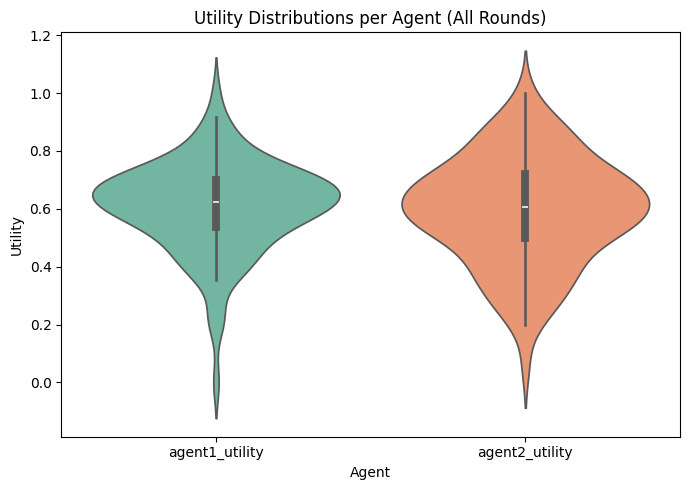

In [247]:
# Utility Distributions per Agent (Violin Plot)
import matplotlib.pyplot as plt
import seaborn as sns

if 'metrics_df' in globals() and not metrics_df.empty:
    # Prepare data for plotting
    plot_df = metrics_df[['agent1_utility', 'agent2_utility']].copy()
    plot_df = plot_df.melt(var_name='Agent', value_name='Utility')

    plt.figure(figsize=(7, 5))
    sns.violinplot(x='Agent', y='Utility', hue='Agent', data=plot_df, inner='box', palette='Set2', legend=False)
    plt.title('Utility Distributions per Agent (All Rounds)')
    plt.xlabel('Agent')
    plt.ylabel('Utility')
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

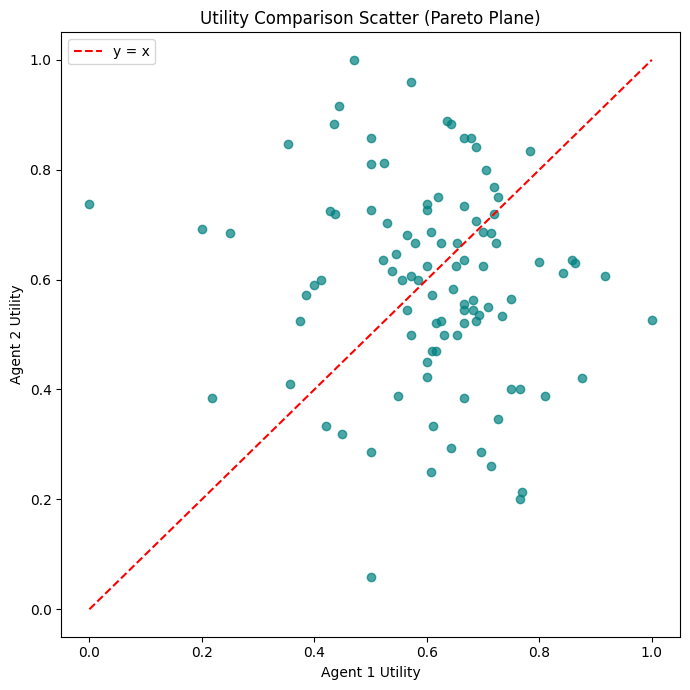

In [248]:
# Utility Comparison Scatter (Pareto Plane)
import matplotlib.pyplot as plt

if 'metrics_df' in globals() and not metrics_df.empty:
    plt.figure(figsize=(7, 7))
    plt.scatter(metrics_df['agent1_utility'], metrics_df['agent2_utility'], alpha=0.7, color='teal')
    # Add y=x reference line
    min_util = min(metrics_df['agent1_utility'].min(), metrics_df['agent2_utility'].min())
    max_util = max(metrics_df['agent1_utility'].max(), metrics_df['agent2_utility'].max())
    plt.plot([min_util, max_util], [min_util, max_util], 'r--', label='y = x')
    plt.xlabel('Agent 1 Utility')
    plt.ylabel('Agent 2 Utility')
    plt.title('Utility Comparison Scatter (Pareto Plane)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

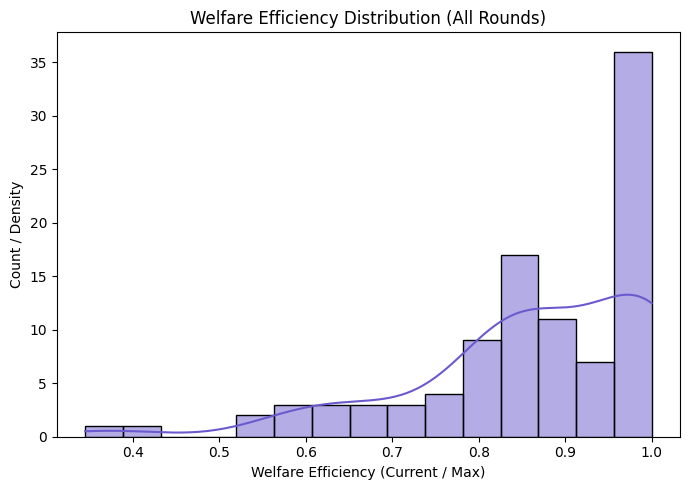

In [249]:
# Welfare Efficiency Distribution (Histogram/KDE)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'metrics_df' in globals() and not metrics_df.empty:
    # Copy and prep data
    eff_vals = metrics_df['welfare_efficiency'].dropna()
    plt.figure(figsize=(7, 5))
    sns.histplot(eff_vals, kde=True, bins=15, color='slateblue', edgecolor='black')
    plt.title('Welfare Efficiency Distribution (All Rounds)')
    plt.xlabel('Welfare Efficiency (Current / Max)')
    plt.ylabel('Count / Density')
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")

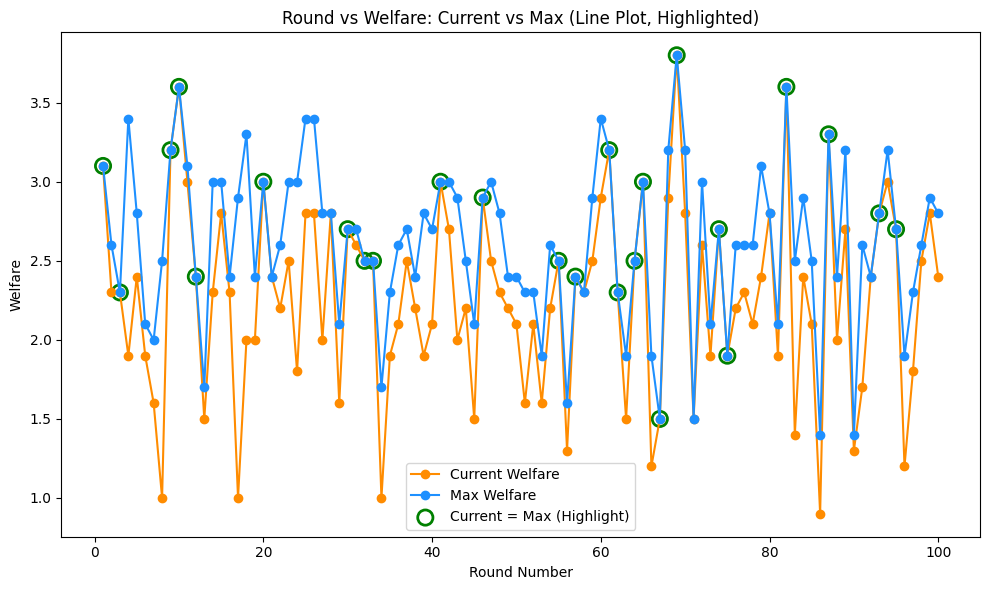

In [250]:
# Line Plot: Round vs Welfare (Current & Max) with Highlighted Max Matches
import matplotlib.pyplot as plt

if 'metrics_df' in globals() and not metrics_df.empty:
    plot_df = metrics_df.copy()
    plt.figure(figsize=(10, 6))
    # Plot lines
    plt.plot(plot_df['round_number'], plot_df['current_welfare'], marker='o', color='darkorange', label='Current Welfare')
    plt.plot(plot_df['round_number'], plot_df['max_welfare'], marker='o', color='dodgerblue', label='Max Welfare')
    # Highlight points where current welfare == max welfare
    matches = plot_df[plot_df['current_welfare'] == plot_df['max_welfare']]
    plt.scatter(matches['round_number'], matches['current_welfare'], facecolors='none', edgecolors='green', s=120, linewidths=2, label='Current = Max (Highlight)')
    plt.xlabel('Round Number')
    plt.ylabel('Welfare')
    plt.title('Round vs Welfare: Current vs Max (Line Plot, Highlighted)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("metrics_df not available yet. Run the loading cells above.")